# List Runs

In [1]:
root = "../data/081221_final_fishhook_tests"
run_list = '.run_list.temp'
!ls {root} -1 | tee {run_list}

pretest_1
pretest_2
stationary_1
stationary_2
stationary_3
stationary_4
stationary_5
stationary_6
stationary_7
stationary_8
triangle_1
triangle_2
triangle_3


In [2]:
runs = [a.strip() for a in open(run_list) if a != '']

In [3]:
fs = 100
dt = 1.0 / fs

# Helpers

In [4]:
import numpy as np

from scipy.signal import butter, lfilter, filtfilt, hilbert
class BP:
    def __init__(self, fs=fs, low=30e3, high=50e3, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, [low / nyq, high / nyq], btype='band')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)
    
class LP:
    def __init__(self, fs=fs, low=30, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, low / nyq, btype='lowpass')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)


In [5]:
import numpy as np

def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# Load Run

In [5]:
import numpy as np

In [90]:
run = runs[runs.index('triangle_3')]  #runs[8]
run

'triangle_3'

In [91]:
imu_file = f"{root}/{run}/imu.csv"
times_file = f"{root}/{run}/times.log"
!du -h {imu_file}
!cat {times_file}

1.6M	../data/081221_final_fishhook_tests/triangle_3/imu.csv
cat: ../data/081221_final_fishhook_tests/triangle_3/times.log: No such file or directory


In [92]:
imu_orig = np.loadtxt(imu_file, delimiter=',', skiprows=1)

In [93]:
imu_orig = np.loadtxt(f'{imu_file}', delimiter=',', skiprows=1)

imu = imu_orig.copy()
imu[:, 0] -= imu_orig[0,0]
# imu[:, 4:6] -= imu[:int(fs * 2), 4:6].mean(axis=0)
imu_labels = open(imu_file).readline().strip().split(', ')[1:]
print(open(imu_file).readline().strip().split(', '))

['time', 'yaw', 'pitch', 'roll', 'a_n', 'a_e', 'a_d', 'w_y', 'w_p', 'w_r']


In [94]:
# t = imu_orig[:, 0] - imu_orig[0,0]
# imu = imu_orig[:, 1:].copy()
# imu[:, 3:6] -= imu[:int(fs * 5), 3:6].mean(axis=0)
# imu[:, 6:9] -= imu[:int(fs * 5), 6:9].mean(axis=0)
# imu_labels = open(imu_file).readline().strip().split(', ')[1:]
# print(open(imu_file).readline().strip().split(', '))

In [95]:
# imu[:, 3:6] = LP(fs=fs, low=30)(imu_orig[:, 4:7])

In [96]:
times = {}
for l in open(times_file, 'r'):
    vals = l[:-1].split(' ')[0:2]
    times[float(vals[0]) - imu_orig[0,0]] = vals[1]

# times

FileNotFoundError: [Errno 2] No such file or directory: '../data/081221_final_fishhook_tests/triangle_3/times.log'

# Simple Viz

In [13]:
import matplotlib.pyplot as plt

In [14]:
imu[:, 3:6] = LP(fs=fs, low=5)(imu_orig[:, 4:7])

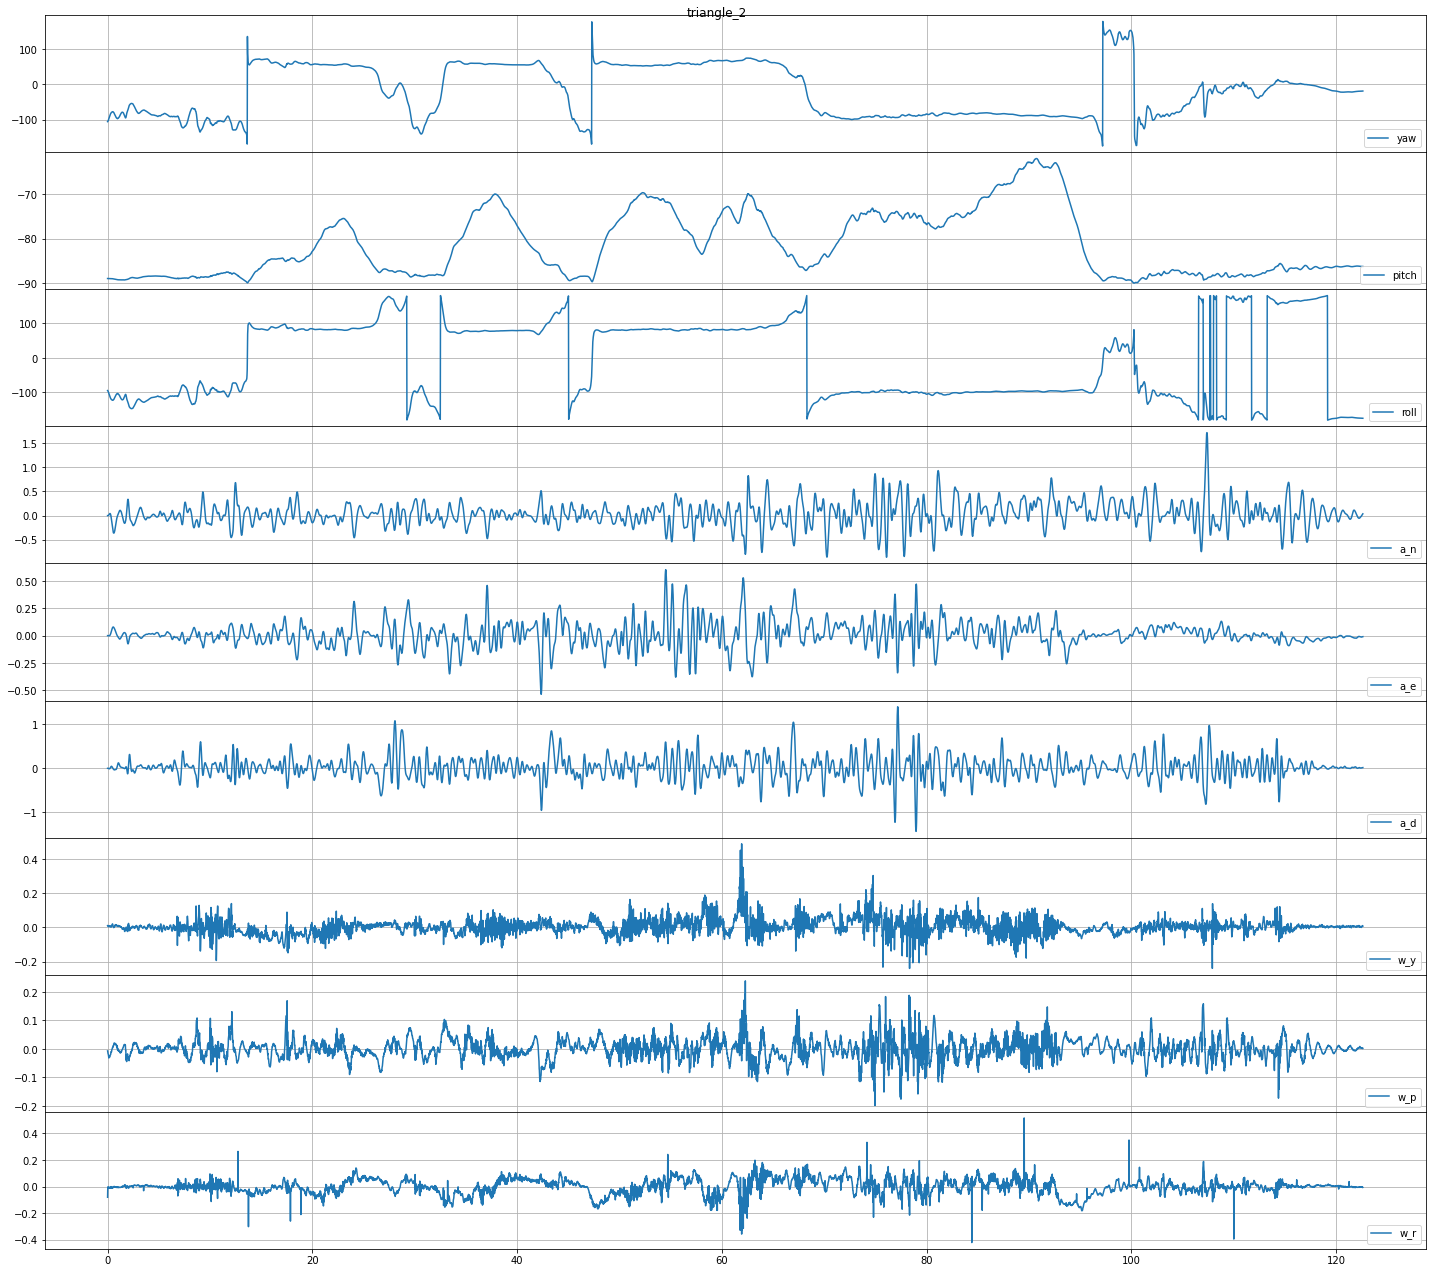

In [15]:
f, ax = plt.subplots(imu.shape[1], 1, figsize=(20, 2 * imu.shape[1]), sharex=True)

for i in range(imu.shape[1]):
    ax[i].plot(t, imu[:, i], label=imu_labels[i])
    for tt in times.keys():
        ax[i].axvline(tt, color='red')
    ax[i].grid()
    ax[i].legend(loc='lower right')
f.suptitle(run)
f.tight_layout()
f.subplots_adjust(wspace=0, hspace=0)
plt.show()

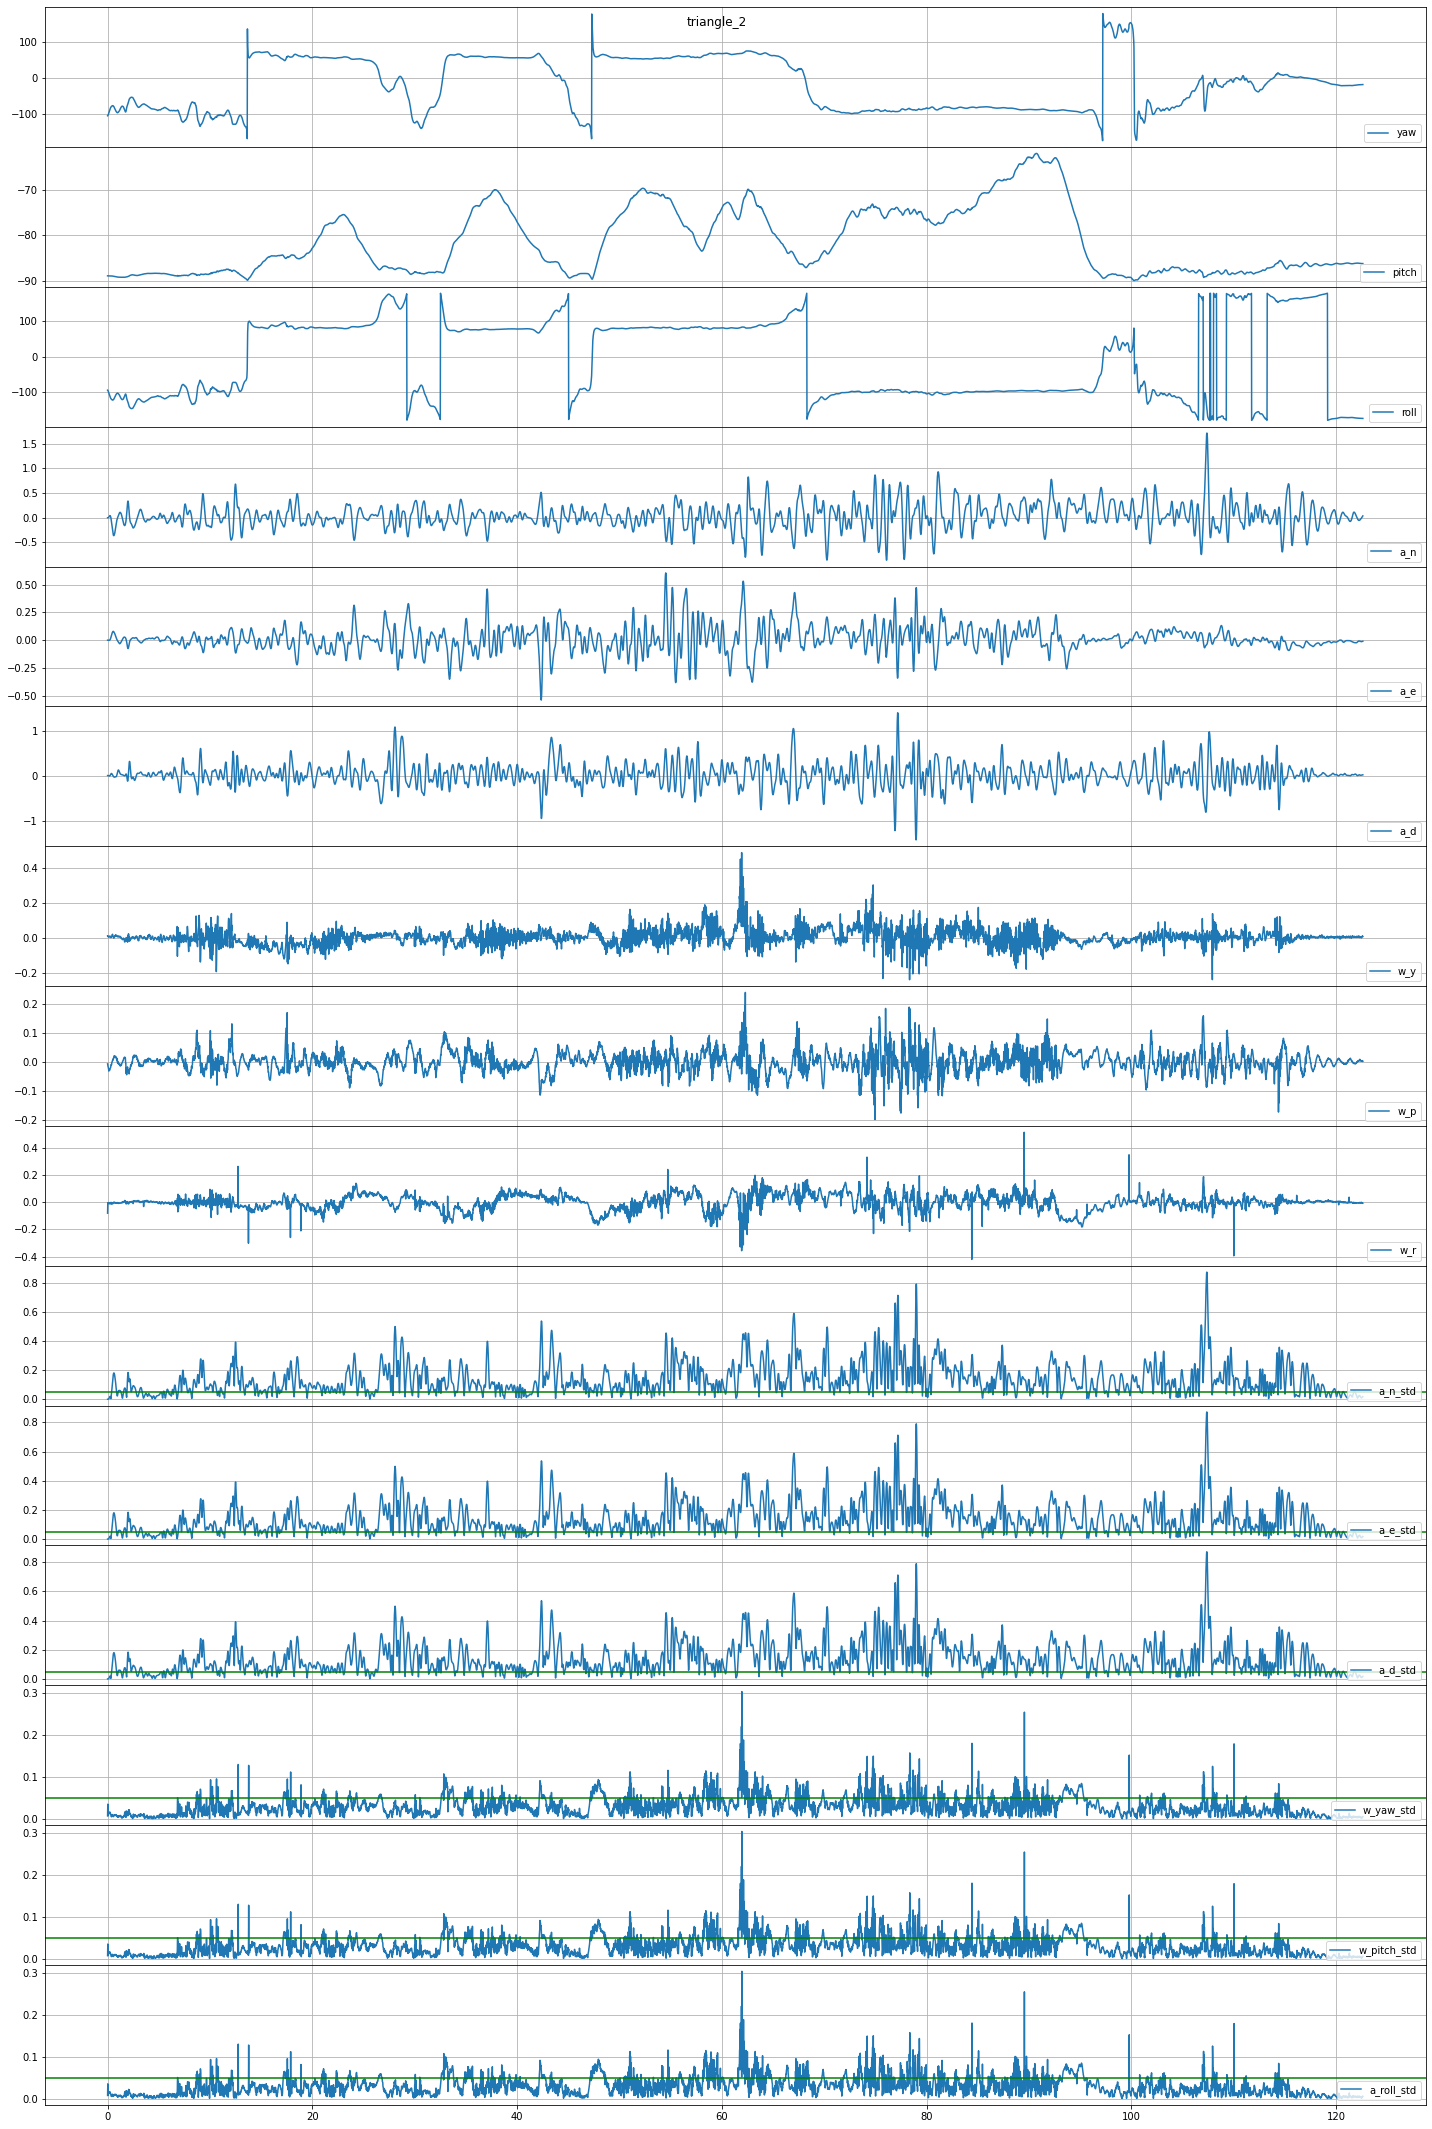

In [16]:
f, ax = plt.subplots(imu.shape[1] + 6, 1, figsize=(20, 2 * (imu.shape[1] + 6)), sharex=True)

for i in range(imu.shape[1]):
    ax[i].plot(t, imu[:, i], label=imu_labels[i])
    for tt in times.keys():
        ax[i].axvline(tt, color='red')
    ax[i].grid()
    ax[i].legend(loc='lower right')
    
acc_std = rolling_window(imu[:, 3:6], int(fs * 0.4)).std(axis=-1)

for a, std, name in zip(ax[imu.shape[1]:(imu.shape[1] + 3)], acc_std.T, ('a_n_std', 'a_e_std', 'a_d_std',)):
    a.plot(t, std[:-1], label=name)
    for tt in times.keys():
        a.axvline(tt, color='red')
    a.axhline(0.05, color='green')
    a.grid()
    a.legend(loc='lower right')
    

w_std = rolling_window(imu[:, 6:9], int(fs * 0.4)).std(axis=-1)

for a, std, name in zip(ax[imu.shape[1] + 3:(imu.shape[1] + 6)], w_std.T, ('w_yaw_std', 'w_pitch_std', 'a_roll_std',)):
    a.plot(t, std[:-1], label=name)
    for tt in times.keys():
        a.axvline(tt, color='red')
    a.axhline(0.05, color='green')
    a.grid()
    a.legend(loc='lower right')
    
    
f.suptitle(run)
f.tight_layout()
f.subplots_adjust(wspace=0, hspace=0)
plt.show()

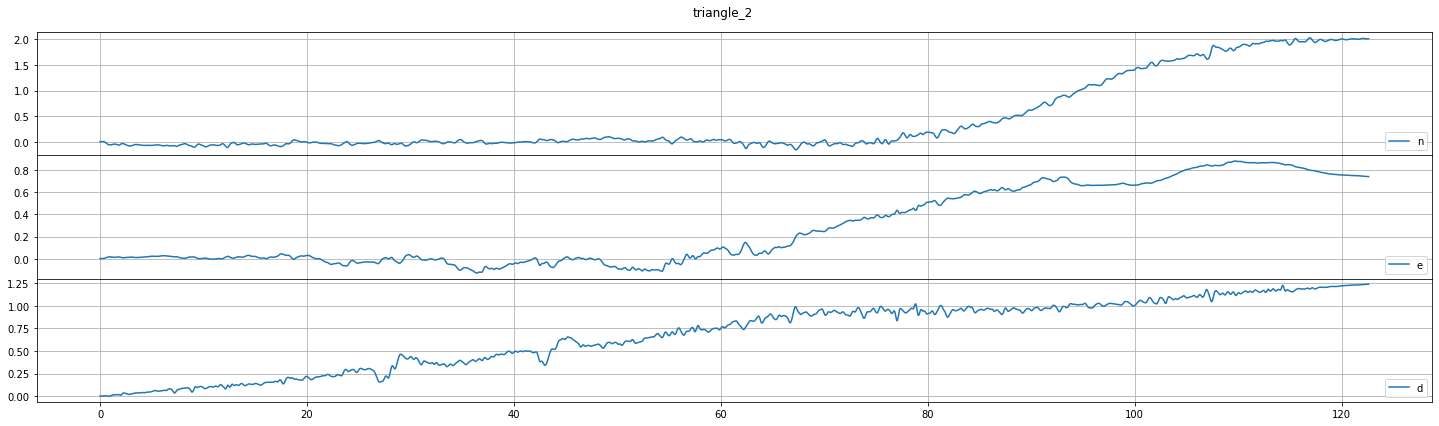

In [17]:
v = dt * np.cumsum(imu[:, 3:6], axis=0)

f, ax = plt.subplots(v.shape[1], 1, figsize=(20, 2 * v.shape[1]), sharex=True)

for i in range(v.shape[1]):
    ax[i].plot(t, v[:, i], label=('n e d'.split(' '))[i])
    for tt in times.keys():
        ax[i].axvline(tt, color='red')
    ax[i].grid()
    ax[i].legend(loc='lower right')
f.suptitle(run)
f.tight_layout()
f.subplots_adjust(wspace=0, hspace=0)
plt.show()

# NEw

In [97]:
zero_state = imu[slice(0, int(fs * 5)), 2:4].mean(axis=0)
imu_dev = imu[:, 2:4] - zero_state
imu_dev = np.rad2deg(np.unwrap(np.deg2rad(imu_dev), axis=0))
imu_dev = np.abs(imu_dev / 180)
in_motion = np.linalg.norm(imu_dev, axis=1) > 0.25

In [98]:
in_motion = imu_dev[:, 0] > 0.02

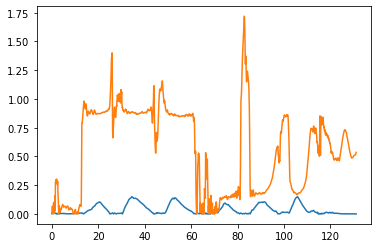

In [99]:
plt.plot(imu[:, 0], imu_dev)

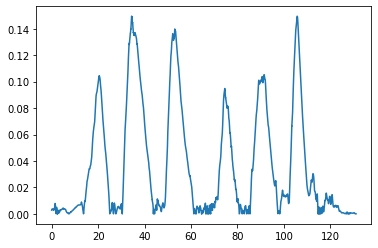

In [100]:
plt.plot(imu[:, 0], imu_dev[:,0])

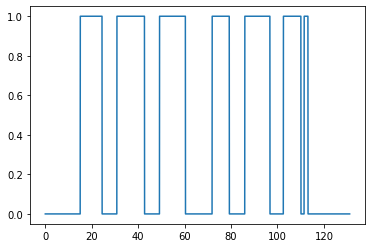

In [101]:
plt.plot(imu[:, 0], in_motion)


In [102]:
all_indices = np.where(np.diff(in_motion))[0]
all_indices = all_indices[:len(all_indices) - (len(all_indices)%2)]
all_indices = np.insert(all_indices, 0, 0)
all_indices = np.insert(all_indices, all_indices.shape[0], in_motion.shape[0])

In [103]:
zero_state = imu[slice(0, int(fs * 5)), 4:7].mean(axis=0)
acc_dev = imu[:, 4:7] - zero_state

In [106]:
vel = np.cumsum(acc_dev[:, :], axis=0) * dt
vel_cor = vel.copy()
indices = all_indices

def show_plot(v):
    plt.figure(figsize=(20,4))
    plt.plot(v)

zero_state = True
zero_vel = vel_cor[indices[0]:indices[1]].mean(axis=0)
# show_plot(vel_cor)
for i in range(len(indices) - 1):
    if zero_state:
        # vel_cor[indices[i]:indices[i+1]] -= zero_vel
        vel_cor[indices[i]:indices[i+1]] = 0
        vel_cor[indices[i+1]:] -= zero_vel
#         show_plot(vel_cor)
    else:
        zero_vel = vel_cor[indices[i+1]:indices[i+2]].mean(axis=0)
        vel_cor[indices[i]:indices[i+1], ...] -= vel_cor[indices[i]]
        vel_cor[indices[i]:indices[i+1], ...] -= (vel_cor[indices[i+1]] * np.linspace(0, 1, indices[i+1] - indices[i])[:, None])
        
#         show_plot(vel_cor)

    zero_state = not zero_state

In [107]:
# plt.plot(imu[:, 0], vel)

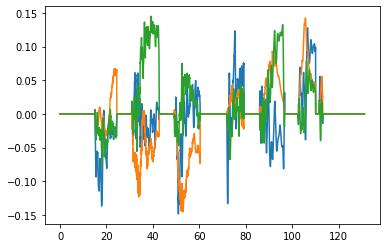

In [108]:
for time, label in times.items():
    plt.axvline(x=time, color='black', alpha=0.4)#, label=(label if label != '' else None))
plt.plot(imu[:, 0], vel_cor)

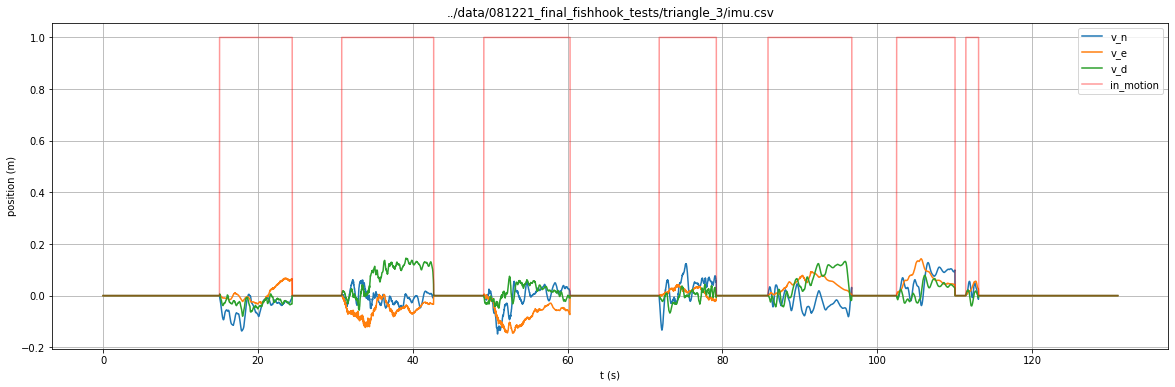

In [109]:
plt.figure(figsize=(20,6))
plt.title(imu_file)

for v, label in zip(vel_cor.T, ('v_n', 'v_e', 'v_d')):
    plt.plot(imu[:, 0], v, label=label)

plt.plot(imu[:, 0], in_motion, color='red', label='in_motion', alpha=0.4)

for time, label in times.items():
    plt.axvline(x=time, color='black', alpha=0.4)#, label=(label if label != '' else None))

plt.legend()
plt.grid()
plt.xlabel('t (s)')
plt.ylabel('position (m)')
plt.show()


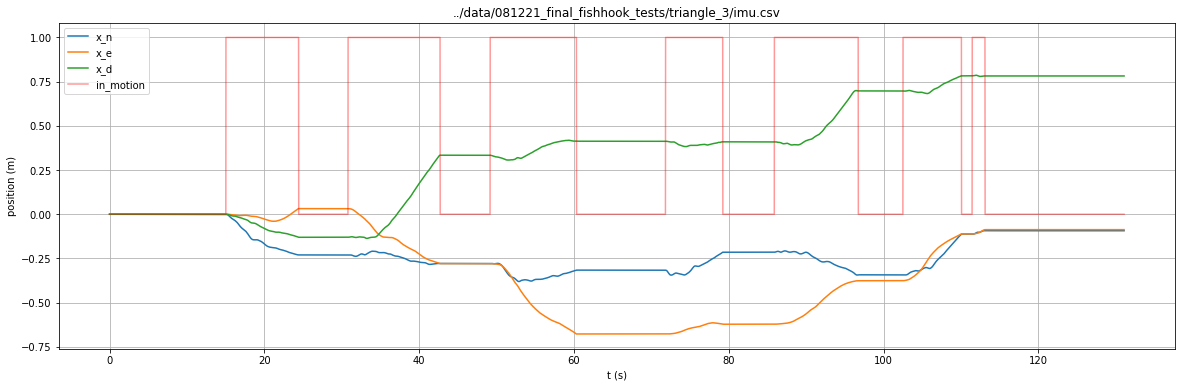

In [110]:
plt.figure(figsize=(20,6))
plt.title(imu_file)

for v, label in zip(vel_cor.T, ('x_n', 'x_e', 'x_d')):
    plt.plot(imu[:, 0], np.cumsum(v, axis=0) * dt, label=label)

plt.plot(imu[:, 0], in_motion, color='red', label='in_motion', alpha=0.4)

for time, label in times.items():
    plt.axvline(x=time, color='black', alpha=0.4)#, label=(label if label != '' else None))

plt.legend()
plt.grid()
plt.xlabel('t (s)')
plt.ylabel('position (m)')
plt.show()


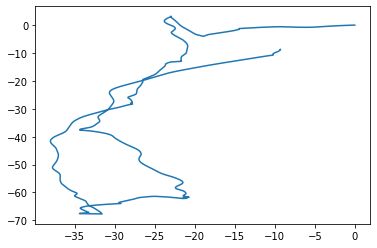

In [111]:
plt.plot(np.cumsum(vel_cor[:,0]), np.cumsum(vel_cor[:,1]))

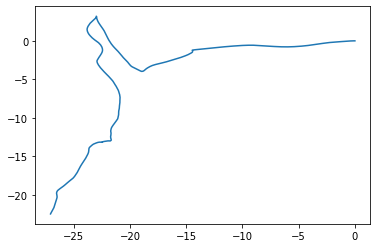

In [112]:
win = slice(0, int(fs * 20))
plt.plot(np.cumsum(vel_cor[win,0]), np.cumsum(vel_cor[win,1]))